# [약품식별 인공지능 개발을 위한 경구 약제 이미지 분류]
- 경구약제 약품식별 결과를 안내하고 피드백할 수 있는 AI 서비스 모델이 요구되며, 이를 위해 학습용 경구약제 이미지데이터 셋과 약품 정보를 분류하는 것이 필요

- 개발 내용
  - 이미지 데이터 전처리 및 데이터 확인
  - 이미지 처리 기술을 활용하여 경구 약제 이미지 분류
- 필요 기술 스택
  - Python, Pillow or Opencv, Deep learning
  - Git
- Dataset
  - https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=576







[추가 내용]
- 단일 선택 시, 데이터가 커져 전처리가 힘들지만, 모델링은 수월
- 조합 선택 시, 전처리는 쉽지만, 그만큼 모델링에서 특화된 부분으로 보여주어야 함

# 0. 데이터 전처리
- colab에서 실행 불가

In [ ]:
import json
import glob
import cv2
import os

dir_1 = glob.glob('Data/1.Training/labeling_data/drug/*')
json_names = []
for temp_dir in dir_1:
    json_names += glob.glob(temp_dir + '/*.*')
# print(json_names[:3])

temp_img_dir = glob.glob('Data/1.Training/raw_data/drug/*')
# print(len(temp_img_dir))
img_names = []
for temp in temp_img_dir:
    img_names += glob.glob(temp + '/*.*')

# print(img_names[:10])
i = 0
# os.mkdir('Data/1.Training/images/' + 'hi')
for idx, img_data in enumerate(json_names):
    img_data = img_data.replace('\\', '/', 10)
    # print(img_data)
    with open(img_data, 'r', encoding='UTF=8') as j:
        js = json.load(j)
        file_name = js['images'][0]['file_name']
        file_dir = 'Data/1.Training/images/' + file_name[:8]
        if not os.path.isdir(file_dir):
            os.mkdir(file_dir)

        file_dir = file_dir + '/' + file_name

        if not os.path.isfile(file_dir):
            # print(file_dir)
            x, y, w, h = js['annotations'][0]['bbox']

            cx = x + w // 2
            cy = y + h // 2
            w_h, h_h = max(w, h), max(w, h)  # 깨끗한 data 를 얻기 위해 크롭영역을 정방형으로 해준다. 기준은 둘 중 큰 값
            x = cx - (w_h // 2)
            y = cy - (h_h // 2)

            # print(x, y, w, h)
            img_names[idx] = img_names[idx].replace('\\', '/', 10)
            # print(img_names[idx])
            img = cv2.imread(img_names[idx], cv2.IMREAD_COLOR)
            cropped_img = img[y:y + h_h, x:x + w_h]
            cropped_img = cv2.resize(cropped_img, (64, 64))
            if idx % 100 == 0:
                print('진행상황: {} / {}'.format(idx, len(img_names)))
            cv2.imwrite(file_dir, cropped_img)
        else:
            print('이미 처리한 데이터 입니다.')
            continue

# 1. 구글 드라이브 마운드

In [2]:
#google drive 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. 라이브러리 import

In [3]:
#import lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow
import torch
import pandas
import seaborn as sns

import glob #파일명 다 긁어오기
import PIL
import cv2 #이미지 데이터 전처리, 이미지 불러오기

import imageio #이미지 불러오기
import skimage # Numpy배열로 이미지 객체를 다룬다.
import skimage.io
import skimage.transform

from sklearn.model_selection import train_test_split

# 3. csv 파일 읽어오기
- csv: 데이터 폴더 엑셀화한 문서

In [4]:
df = pd.read_csv('/content/drive/MyDrive/SWBootcamp_Personal/DataSet.csv')

In [5]:
df.sample(100).head()

,Name,Extension,Date accessed,Date modified,Date created,Folder Path
8022,K-039146_0_2_0_1_90_240_200.png,.png,2021-09-09 14:44,2021-09-09 14:44,2021-09-09 14:44,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
5036,K-039047_0_2_1_2_70_280_200.png,.png,2021-11-17 10:55,2021-11-17 10:55,2021-11-17 10:55,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
3489,K-038962_0_2_1_1_75_300_200.png,.png,2021-11-18 15:35,2021-11-18 15:35,2021-11-18 15:35,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
7917,K-039146_0_2_0_0_70_300_200.png,.png,2021-09-09 14:44,2021-09-09 14:44,2021-09-09 14:44,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
8323,K-039147_0_0_0_0_60_140_200.png,.png,2021-09-07 16:19,2021-09-07 16:19,2021-09-07 16:19,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...


In [6]:
df.head()

,Name,Extension,Date accessed,Date modified,Date created,Folder Path
0,K-038884_0_0_0_0_75_000_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
1,K-038884_0_0_0_0_75_020_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
2,K-038884_0_0_0_0_75_040_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
3,K-038884_0_0_0_0_75_060_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
4,K-038884_0_0_0_0_75_080_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...


In [7]:
df

,Name,Extension,Date accessed,Date modified,Date created,Folder Path
0,K-038884_0_0_0_0_75_000_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
1,K-038884_0_0_0_0_75_020_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
2,K-038884_0_0_0_0_75_040_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
3,K-038884_0_0_0_0_75_060_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
4,K-038884_0_0_0_0_75_080_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
...,...,...,...,...,...,...
9607,K-039147_0_2_1_2_90_260_200.png,.png,2021-09-07 16:25,2021-09-07 16:25,2021-09-07 16:25,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
9608,K-039147_0_2_1_2_90_280_200.png,.png,2021-09-07 16:25,2021-09-07 16:25,2021-09-07 16:25,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
9609,K-039147_0_2_1_2_90_300_200.png,.png,2021-09-07 16:25,2021-09-07 16:25,2021-09-07 16:25,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...
9610,K-039147_0_2_1_2_90_320_200.png,.png,2021-09-07 16:25,2021-09-07 16:25,2021-09-07 16:25,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...


# 4. DataFrame 파일명, 종류로 정리

In [8]:
df['Name'] = df['Name'].astype('str')
df['Name'].dtypes

Name_list = df['Name'].str.split('_')
Name_list.head()

df['kind'] = Name_list.str.get(0)
df.head()

,Name,Extension,Date accessed,Date modified,Date created,Folder Path,kind
0,K-038884_0_0_0_0_75_000_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...,K-038884
1,K-038884_0_0_0_0_75_020_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...,K-038884
2,K-038884_0_0_0_0_75_040_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...,K-038884
3,K-038884_0_0_0_0_75_060_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...,K-038884
4,K-038884_0_0_0_0_75_080_200.png,.png,2023-01-10 16:55,2021-10-07 10:48,2021-10-07 10:48,D:\SW BootCamp\개인프로젝트\[2. 약 분류]\data\166.약품식별 ...,K-038884


In [9]:
del df['Extension']
del df['Date accessed']
del df['Date modified']
del df['Date created']
del df['Folder Path']
df

,Name,kind
0,K-038884_0_0_0_0_75_000_200.png,K-038884
1,K-038884_0_0_0_0_75_020_200.png,K-038884
2,K-038884_0_0_0_0_75_040_200.png,K-038884
3,K-038884_0_0_0_0_75_060_200.png,K-038884
4,K-038884_0_0_0_0_75_080_200.png,K-038884
...,...,...
9607,K-039147_0_2_1_2_90_260_200.png,K-039147
9608,K-039147_0_2_1_2_90_280_200.png,K-039147
9609,K-039147_0_2_1_2_90_300_200.png,K-039147
9610,K-039147_0_2_1_2_90_320_200.png,K-039147


# 5. 약 종류 별 개수 출력

In [10]:
df['kind'].value_counts()

K-039147    1296
K-039146    1296
K-039136    1296
K-038954     324
K-039047     324
K-039036     324
K-039021     324
K-038967     324
K-038958     324
K-038962     324
K-038929     324
K-038927     324
K-038910     324
K-038896     324
K-038959     216
K-038890     216
K-038970     216
K-038914     216
K-038913     216
K-038912     216
K-039104     216
K-039108     216
K-039123     216
K-038884     216
Name: kind, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


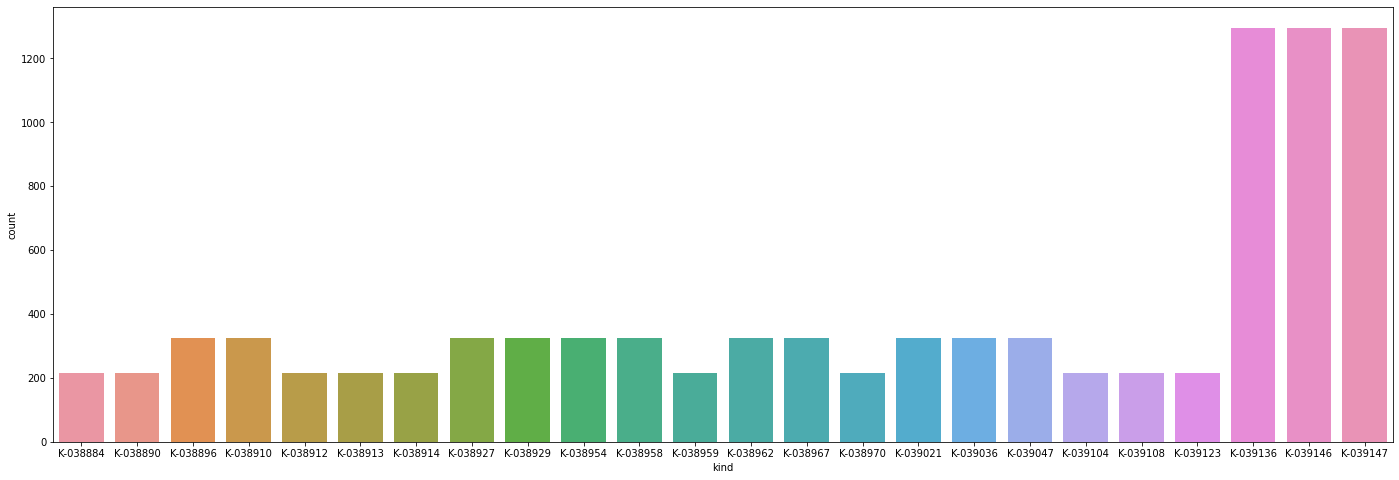

In [11]:
#kind
plt.figure(figsize=(24,8))
sns.countplot(df['kind'])
plt.show()

# 6. 이미지 확인

In [12]:
IMAGE_PATH = '/content/drive/MyDrive/SWBootcamp_Personal/images'

# image_kinds = 실제 이미지 파일 상단 폴더명 모음
image_kinds = list(os.listdir(IMAGE_PATH))
print(image_kinds) #24개
print('image_files len: ' + str(len(image_kinds)))

# image_files = 실제 이미지들 모음
image_files = list(os.listdir(IMAGE_PATH +'/'+ str(image_kinds[0])))
#print(image_files)
for i in range(1, len(image_kinds)):
  image_file_tmp = list(os.listdir(IMAGE_PATH +'/'+ str(image_kinds[i])))
  image_files = image_files + image_file_tmp
  print('image_files len: ' + str(len(image_files)))

#print(image_files)



print("Number of image files: {}".format(len(image_files)))

['K-038884', 'K-038912', 'K-038927', 'K-038954', 'K-038914', 'K-038910', 'K-038896', 'K-038890', 'K-038929', 'K-038913', 'K-038958', 'K-038970', 'K-039108', 'K-038959', 'K-038967', 'K-038962', 'K-039021', 'K-039104', 'K-039047', 'K-039036', 'K-039123', 'K-039136', 'K-039146', 'K-039147']
image_files len: 24
image_files len: 432
image_files len: 756
image_files len: 1080
image_files len: 1296
image_files len: 1620
image_files len: 1954
image_files len: 2170
image_files len: 2494
image_files len: 2710
image_files len: 3034
image_files len: 3250
image_files len: 3466
image_files len: 3682
image_files len: 4006
image_files len: 4330
image_files len: 4654
image_files len: 4870
image_files len: 5194
image_files len: 5518
image_files len: 5734
image_files len: 7040
image_files len: 8336
image_files len: 9632
Number of image files: 9632


In [13]:
file_names = list(df['Name']) #df의 'file' 칼럼 데이터로 리스트 생성 (파일명)

#file_names로 집합을 만들고, image file 이름과 매칭시킨 개수를 구한다.
print("Matching image names: {}".format(len(set(file_names).intersection(image_files))))

Matching image names: 9612


In [14]:
#이미지 그리는 함수
def draw_category_images(var,cols=5):
    categories = (df.groupby([var])[var].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=cols, figsize=(2*cols,2*len(categories)))
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[var]==cat].sample(cols)
        for j in range(0,cols):
            file = IMAGE_PATH + '/' + sample.iloc[j]['kind'] + '/' + sample.iloc[j]['Name']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True)
            ax[i, j].set_title(cat, fontsize=9)  
    plt.tight_layout()
    plt.show()

In [15]:
draw_category_images('kind')  # 24종류 -> 24행 * 5열

Output hidden; open in https://colab.research.google.com to view.

# 7. train/test set 준비

In [16]:
#train set:test set = 0.8:0.2
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1, stratify=df['kind'])

In [17]:
#확인
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))

Train set rows: 7689
Test  set rows: 1923


In [18]:
#이미지 경로에서 읽어오기 (size:200*200)
def read_image(file_name):
  image = skimage.io.imread(IMAGE_PATH + '/' + file_name[0:8] + '/' + file_name)
  image = skimage.transform.resize(image, (200, 200), mode='reflect')
  return image[:,:,:3]

In [22]:
def categories_encoder(dataset, var):
    #file명을 읽어 이미지 경로에서 불러온다. X 값.
    X = np.stack(dataset['Name'].apply(read_image))
    # subspecies를 더미변수화 하여 y값으로
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

===========================================================================================================

In [ ]:
#file명을 읽어 이미지 경로에서 불러온다. X 값.
X_train, y_train = categories_encoder(train_df, 'kind')
X_test, y_test = categories_encoder(test_df, 'kind')

In [ ]:
#개수, size, channel
print(X_train.shape) # (trainset 개수, 크기,크기,rgb)
print(y_train.shape) # (trainset 개수, 몇 개의 subspecies)
print(X_test.shape) # (testset 개수, 크기,크기,rgb)
print(y_test.shape) # (testset 개수, 몇 개의 subspecies)